# Package Preparation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import shutil
from timeit import default_timer
import random

In [ ]:
!pip install transformers
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 359.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=837838aa7dfe5c223a71a1c0581ef8d39f8519f91de61f1a18f168a961d36b48
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


# Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to your specific path.
%cd "drive/Shareddrives/CS 685 Final Project"

/content/drive/Shareddrives/CS 685 Final Project


# Data Processing: WDC Dataset








In [ ]:
def shuffle_and_split_dataset(input_filename, train_pct=0.7, val_pct=0.1, test_pct=0.2):
    data = pd.read_csv(input_filename, encoding='mac_roman', sep=';')
    data = data.sample(frac=1, random_state=42)  # shuffle data

    N = len(data)
    train_counts = int(N * train_pct)
    val_counts = int(N * val_pct)
    test_counts = N - train_counts - val_counts

    # split into train/val/test dataset
    train_data = data[0 : train_counts]
    val_data = data[train_counts : train_counts+val_counts]
    test_data = data[train_counts+val_counts : ]

    return train_data, val_data, test_data


def tokenize_and_format(input_data):
    input_ids = []
    attention_masks = []

    for text in input_data:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences.
                            padding = 'max_length',
                            truncation=True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                        )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks


def tokenize_and_encode_wdc(df_data, feature_col_names, label_col_names, save_filename, tokenizer, encoder):
    # input_ids, attns_masks
    data = df_data
    # fill nan with empty string, in order to concat both feature cols together in next step
    for feature_name in feature_col_names:
        data[feature_name] = data[feature_name].fillna('')

    features = data[feature_col_names[0]] + ' ' + data[feature_col_names[1]]
    features = features.apply(lambda x: x.strip())

    input_ids, attention_masks = tokenize_and_format(features)

    # encode labels
    list_labels = [0] * 3
    for i, col_name in enumerate(label_col_names):
        level_label = data[col_name]
        level_label = level_label.apply(str.lower).str.split('_').apply(lambda x: x[1])
        list_labels[i] = level_label

    clean_labels = [' '.join([l1, l2, l3]) for l1, l2, l3 in zip(list_labels[0],list_labels[1],list_labels[2] )]
    taxonomy_vectors = encoder.encode(clean_labels)
    taxonomy_tensors = torch.Tensor(taxonomy_vectors)
    
    # encode unique labels
    clean_unique_labels =  list(set(clean_labels))
    unique_taxonomy_vectors = encoder.encode(clean_unique_labels)
    unique_taxonomy_tensors = torch.Tensor(unique_taxonomy_vectors)

    # indices of taxonomy_tensors with respect to unique_taxonomy_tensors
    indices_wrt_unique_labels = torch.Tensor([clean_unique_labels.index(x) for x in clean_labels])

    # dataset is a tuple:
    # dataset[0] is list of input_ids, attention_masks, true label encoding
    # dataset[1] is all label tensors encoding
    # dataset[2] is indicies of the data case labels with respect to unique_taxonomy_tensor
    dataset = [(input_ids[i], attention_masks[i], taxonomy_tensors[i]) for i in range(len(input_ids))], \
                unique_taxonomy_tensors, \
                indices_wrt_unique_labels
    torch.save(dataset, save_filename)
    return dataset

## Load pre-processed data

In [ ]:
# each dataset is a tuple:
# dataset[0] is list of input_ids, attention_masks, true label encoding
# dataset[1] is all label tensors encoding
# dataset[2] is indicies of the data case labels with respect to unique_taxonomy_tensor
train_set = torch.load("data/WDC_train_set_mpnet.pt")
val_set = torch.load("data/WDC_val_set_mpnet.pt")
test_set = torch.load("data/WDC_test_set_mpnet.pt")

# Helper functions (Recall_at_k and Precision_at_k)


In [ ]:
def recall_at_k(topk_indices, test_indices, verbose=False):  # topk_indices shape: m x k, test_indices: list len m.   
    # k is implicitly the 2nd dimension of topk_indices
    correctly_pred = 0
    num_instances = len(test_indices)
    for i in range(num_instances):
      if test_indices[i] in topk_indices[i]:
        correctly_pred += 1
    if verbose:
      print('correctly pred: ', correctly_pred, ', total # of data instances: ', num_instances)
    return correctly_pred, correctly_pred / num_instances

In [ ]:
def precision_at_k(topk_indices, test_indices, verbose=False):  # topk_indices shape: m x k, test_indices: list len m.   
    # k is implicitly the 2nd dimension of topk_indices
    correctly_pred, _ = recall_at_k(topk_indices, test_indices)
    num_preds = len(test_indices) * topk_indices.shape[1]
    if verbose:
      print('correctly pred:', correctly_pred, ', total # of preds: ', num_preds)
    return correctly_pred / num_preds

# Model Definition

Hinge Rank Loss:

$loss(text,label) \leftarrow \sum\limits_{j \neq label} \max\Big(0, margin-cos(T_{emb},v(label)) + cos(T_{emb},v(j)) \Big)$

In [ ]:
class MulticlassClassifier(nn.Module):
  def __init__(self, bert_model_name, output_dim=1024):
    super(MulticlassClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name, output_hidden_states=False, output_attentions=False)
    self.fc1 = nn.Linear(768, 384)  
    self.fc2 = nn.Linear(384, output_dim)  

  def forward(self, tokens, attn_masks):
    out0 = self.bert(tokens, attention_mask=attn_masks)
    out1 = out0[1]  # pooler_output
    out2 = self.fc1(out1)  
    out3 = self.fc2(out2)  
    return out3


In [ ]:
# function to get validation accuracy
def test(model, test_set):
    test_hinge_loss = HingeRankLoss(0.1)
    # Put the model in evaluation mode - no drop out during eval
    model.eval()

    all_labels = test_set[1]
    all_labels = all_labels.to(device)

    test_set = test_set[0]

    # Tracking variables 
    total_test_loss = 0
    all_outputs = torch.Tensor().to(device)

    num_batches = int(len(test_set)/batch_size) + 1


    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(test_set))

      batch = test_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass
        b_outputs = model(b_input_ids, 
                        b_input_mask)
        loss = test_hinge_loss.forward(b_outputs, b_labels, all_labels)

        # Append current outputs to all outputs
        all_outputs = torch.cat((all_outputs, b_outputs), dim=0)
            
        # Accumulate the validation loss.
        total_test_loss += loss.item()


    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_set)
  
    return all_outputs, avg_test_loss



In [ ]:
def train(model, optimizer, train_set, output_dir, model_name):
    summary_stats = []

    hinge_loss = HingeRankLoss(0.1)

    early_stopper = EarlyStopper(patience=5, min_delta=0)

    all_labels = train_set[1]
    all_labels = all_labels.to(device)  # shape: n x 768, where n is number of unique labels
    
    train_set = train_set[0]

    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        start_time = default_timer()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode.
        model.train()

        # For each batch of training data...
        num_batches = int(len(train_set)/batch_size) + 1

        for i in range(num_batches):
            if i % 40 == 0 and i > 0:
                print('Batch {} of {}.'.format(i, num_batches))
            end_index = min(batch_size * (i+1), len(train_set))

            batch = train_set[i*batch_size:end_index]

            if len(batch) == 0: continue

            input_id_tensors = torch.stack([data[0] for data in batch])
            input_mask_tensors = torch.stack([data[1] for data in batch])
            label_tensors = torch.stack([data[2] for data in batch])

            # Move tensors to the GPU
            b_input_ids = input_id_tensors.to(device)
            b_input_mask = input_mask_tensors.to(device)
            b_labels = label_tensors.to(device)  # shape 32 x 768

            # Clear the previously calculated gradient
            model.zero_grad()

            # Forward pass, calculate logit predictions.
            b_outputs = model(b_input_ids, 
                            b_input_mask)   # shape 32 x 768
           
            loss = hinge_loss.forward(b_outputs, b_labels, all_labels)  # b_outputs shape: 32 x 768
                                                                        # b_labels.shape: 32 x 768
                                                                        # all_labels.shape: n x 768, where n is # of unique labels
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()
          
        avg_train_loss = total_train_loss / len(train_set)
        end_time = default_timer()
        elapsed_time = end_time - start_time
        print('Average train loss: {}'.format(avg_train_loss))

        _, avg_val_loss = test(model, val_set)
        print('Average validation loss: {}'.format(avg_val_loss))

        summary_stats.append(
            {
                'Epoch': epoch_i + 1,
                'Average train loss': avg_train_loss,
                'Validation loss': avg_val_loss,
                'Training time': elapsed_time
            }
        )
                
        if early_stopper.early_stop(model, avg_val_loss, epoch_i + 1, output_dir, model_name):
            print("Early stopping at epoch {}".format(epoch_i + 1))
            break  
    
    return summary_stats


## Loss function

In [ ]:

class HingeRankLoss(nn.Module):
  def __init__(self, margin):
    super(HingeRankLoss, self).__init__()
    self.margin = margin

  def forward(self, output, corr_labels, all_labels):
    cos = nn.CosineSimilarity(dim=2, eps=1e-6)
    loss = torch.relu(self.margin - cos(output[:,None], corr_labels[:,None]) + cos(output[:,None], all_labels) ) # torch.Size([32, num_unique_labels])
    loss = torch.sum(loss)  # scalar tensor
    
    dup_loss = max(self.margin, 0.) * len(output)
    dup_loss = torch.tensor(dup_loss, dtype=torch.float32)
    total_loss = loss - dup_loss

    counts = len(output) * (len(all_labels) - 1)
    return total_loss / counts


## Early Stopper, Save Checkpoint, Plot Loss





In [ ]:
def save_checkpoint(state_dict, is_best, epoch, output_dir, model_name):
    # checkpoints are saved under /checkpoints folder
    # best model saved under /models folder
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    checkpoints_dir = './checkpoints'  
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    checkpoint_file = os.path.join(checkpoints_dir, f'{model_name}_checkpoint_{epoch}.pth.tar')
    torch.save(state_dict, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, os.path.join(output_dir, f'{model_name}_best.pth.tar'))


class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.counter = 0
        self.min_delta = min_delta
        self.min_val_loss = np.inf

    def early_stop(self, model, val_loss, epoch, output_dir, model_name):
        if val_loss < self.min_val_loss + self.min_delta:
            print(f'=> Model at epoch {epoch} is the best according to validation loss')
            save_checkpoint(state_dict=model.state_dict(), is_best=True, epoch=epoch, output_dir=output_dir, model_name=model_name)
            self.min_val_loss = val_loss
            self.counter = 0
        else:
            save_checkpoint(state_dict=model.state_dict(), is_best=False, epoch=epoch, output_dir=output_dir, model_name=model_name)
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def plot_train_val_loss(training_stats, save_figure_path):
    # transform to dataframe
    data = pd.DataFrame(data=training_stats)

    # plot
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(data['Average train loss'], '-o', label="Training Loss")
    plt.plot(data['Validation loss'], '-o', label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(save_figure_path)
    plt.show()
        

# For MPNET

## Data Processing

In [ ]:
encoder_mpnet = SentenceTransformer('all-mpnet-base-v2')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

*************

In [ ]:
train_data, val_data, test_data = shuffle_and_split_dataset('./data/goldstandard_eng_v1.csv')


val_set = tokenize_and_encode_wdc(df_data=val_data, 
                                        feature_col_names=["s:name","s:description"], 
                                        label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"], 
                                        save_filename="./data/WDC_val_set_mpnet.pt", 
                                        tokenizer=tokenizer, 
                                        encoder=encoder_mpnet)


train_set = tokenize_and_encode_wdc(df_data=train_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_train_set_mpnet.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_mpnet)


test_set = tokenize_and_encode_wdc(df_data=test_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_test_set_mpnet.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_mpnet)          

## Training

In [ ]:
model = MulticlassClassifier('bert-base-uncased', output_dim=768)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
##### DO NOT RUN THIS CELL IF WANT TO LOAD AND RUN FROM CHECKPOINT !!!!!

##### STILL NEED TO RUN ALL PREVIOUS CELLS EVEN IF LOADING MODEL FROM CHECKPOINT

##### ONLY RUN THIS CELL IF WANT TO TRAIN THE MODEL AGAIN

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
transformers.set_seed(seed)

epochs = 30 # 30

batch_size = 32

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8) # adam_epsilon to avoid divide by 0

summary_stats = train(model, optimizer, train_set, output_dir='./models', model_name='WDC_BERT_MPNET')


======== Epoch 1 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 7.294457140747873e-05
Average validation loss: 0.0001808949797715029
=> Model at epoch 1 is the best according to validation loss

======== Epoch 2 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 6.531403954906334e-05
Average validation loss: 0.00018190234807892547

======== Epoch 3 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 3.5761892071647236e-05
Average validation loss: 0.00015161921599942245
=> Model at epoch 3 is the best according to validation loss

======== Epoch 4 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 2.415084524621413e-05
Average validation loss: 0.00014372491798559693
=> Model at epoch 4 is the best according to validation loss

======== Epoch 5 / 30 ========
Batch 40 of 183.


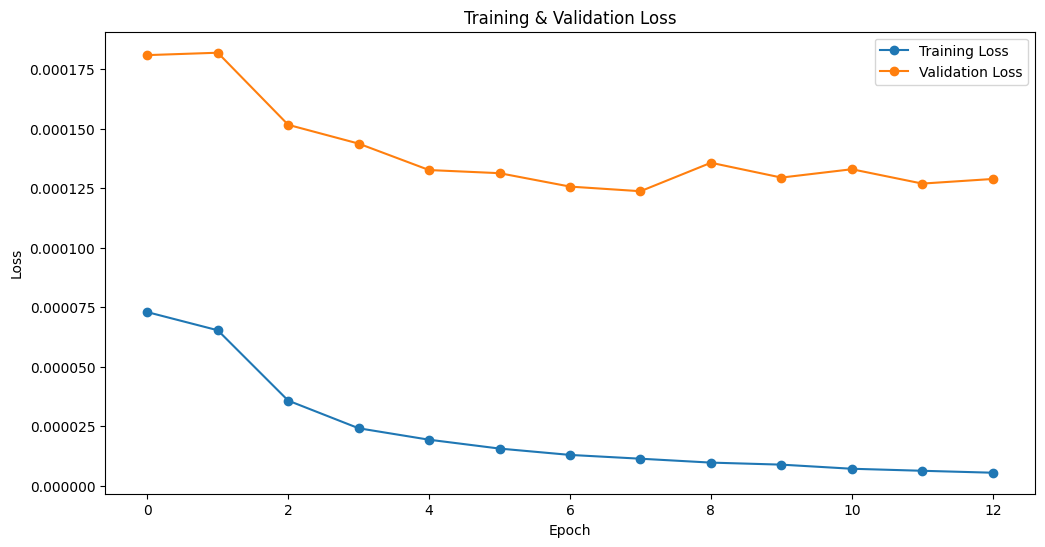

In [ ]:
plot_train_val_loss(summary_stats, save_figure_path="./figures/WDC_BERT_MPNET_train_val_loss.png")

## Evaluation

In [ ]:
model =  MulticlassClassifier('bert-base-uncased', output_dim=768)
model.load_state_dict(torch.load('models/WDC_BERT_MPNET_best.pth.tar'))
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)


test_outputs, _ = test(model, test_set) 
test_outputs = test_outputs.to('cpu')  # shape L x 768

test_outputs.shape, test_outputs.device, test_set[1].device

(torch.Size([1673, 768]), device(type='cpu'), device(type='cpu'))

In [ ]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
unique_labels = test_set[1]  # shape: b x 768

# test_outputs shape: a x 768, unique_labels shape: b x 768
similarity = cos(test_outputs[:,None], unique_labels) # shape: len(test_outputs) x len(unique_labels)
test_indices = test_set[2]  # ground truth


for val in [5, 10, 15, 20]:
  _, topk_indices = torch.topk(similarity, k=val, largest=True)
  _, recall = recall_at_k(topk_indices, test_indices)
  print('Recall at k={}:'.format(topk_indices.shape[1]), recall)
  prec = precision_at_k(topk_indices, test_indices)
  print('Precision at k={}:'.format(topk_indices.shape[1]), prec, '\n')

Recall at k=5: 0.9079497907949791
Precision at k=5: 0.1815899581589958 

Recall at k=10: 0.9444112372982666
Precision at k=10: 0.09444112372982666 

Recall at k=15: 0.9575612671846981
Precision at k=15: 0.06383741781231321 

Recall at k=20: 0.9635385534967125
Precision at k=20: 0.048176927674835626 



******************

# For Sentence BERT


## Data Processing

In [ ]:
encoder_bert_large = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_data, val_data, test_data = shuffle_and_split_dataset('./data/goldstandard_eng_v1.csv')

val_set = tokenize_and_encode_wdc(df_data=val_data, 
                                        feature_col_names=["s:name","s:description"], 
                                        label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"], 
                                        save_filename="./data/WDC_val_set_bert_large.pt", 
                                        tokenizer=tokenizer, 
                                        encoder=encoder_bert_large)


train_set = tokenize_and_encode_wdc(df_data=train_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_train_set_bert_large.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_bert_large)


test_set = tokenize_and_encode_wdc(df_data=test_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_test_set_bert_large.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_bert_large)    

## Training

In [ ]:
model = MulticlassClassifier('bert-base-uncased', output_dim=1024)  # to match output dim of SENT_BERT encoder
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
##### DO NOT RUN THIS CELL IF WANT TO LOAD AND RUN FROM CHECKPOINT !!!!!

##### STILL NEED TO RUN ALL PREVIOUS CELLS EVEN IF LOADING MODEL FROM CHECKPOINT

##### ONLY RUN THIS CELL IF WANT TO TRAIN THE MODEL AGAIN

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
transformers.set_seed(seed)

epochs = 30 # 30

batch_size = 32

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8) # adam_epsilon to avoid divide by 0

summary_stats = train(model, optimizer, train_set, output_dir='./models', model_name='WDC_BERT_SENT_BERT')


======== Epoch 1 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 0.0008517605005410167
Average validation loss: 0.00039338862187001837
=> Model at epoch 1 is the best according to validation loss

======== Epoch 2 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 0.000235160924655004
Average validation loss: 0.00023169391710560716
=> Model at epoch 2 is the best according to validation loss

======== Epoch 3 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 0.00010889559778988346
Average validation loss: 0.00018806551983045262
=> Model at epoch 3 is the best according to validation loss

======== Epoch 4 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 6.440293710435004e-05
Average validation loss: 0.00016615571538833055
=> Model at epoch 4 is the best according to vali

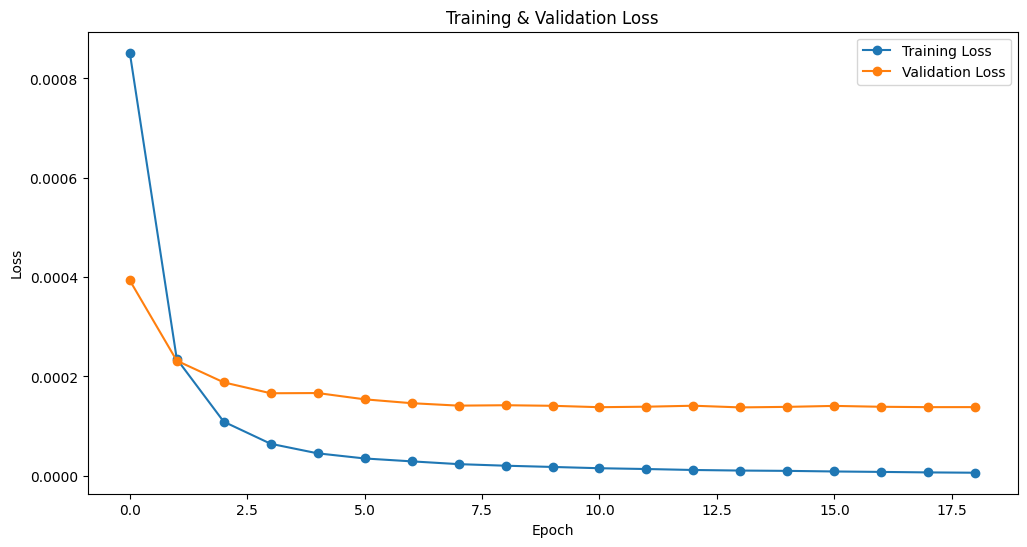

In [ ]:
plot_train_val_loss(summary_stats, save_figure_path="./figures/WDC_BERT_SENT_BERT_train_val_loss.png")

## Evaluation

In [ ]:
model =  MulticlassClassifier('bert-base-uncased', output_dim=1024)
model.load_state_dict(torch.load('models/WDC_BERT_SENT_BERT_best.pth.tar'))
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)


test_outputs, _ = test(model, test_set) 
test_outputs = test_outputs.to('cpu')  # shape L x 768

test_outputs.shape, test_outputs.device, test_set[1].device

(torch.Size([1673, 1024]), device(type='cpu'), device(type='cpu'))

In [ ]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
unique_labels = test_set[1]  # shape: b x 768

# test_outputs shape: a x 768, unique_labels shape: b x 768
similarity = cos(test_outputs[:,None], unique_labels) # shape: len(test_outputs) x len(unique_labels)
test_indices = test_set[2]  # ground truth


for val in [5, 10, 15, 20]:
  _, topk_indices = torch.topk(similarity, k=val, largest=True)
  _, recall = recall_at_k(topk_indices, test_indices)
  print('Recall at k={}:'.format(topk_indices.shape[1]), recall)
  prec = precision_at_k(topk_indices, test_indices)
  print('Precision at k={}:'.format(topk_indices.shape[1]), prec, '\n')

Recall at k=5: 0.9127316198445905
Precision at k=5: 0.18254632396891812 

Recall at k=10: 0.9426180514046623
Precision at k=10: 0.09426180514046623 

Recall at k=15: 0.9539748953974896
Precision at k=15: 0.06359832635983263 

Recall at k=20: 0.9623430962343096
Precision at k=20: 0.04811715481171548 



# For USE

## Universal Sentence Encoder

In [ ]:
class USEEmbedding(): 
    def __init__(self, module_url="https://tfhub.dev/google/universal-sentence-encoder-large/5"):
        self.model = hub.load(module_url)
    
    def encode(self, input):
      output = self.model(input)
      return torch.tensor(output.numpy())  # convert to torch tensor

## Data Processing

In [ ]:
encoder_use = USEEmbedding("https://tfhub.dev/google/universal-sentence-encoder-large/5")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_data, val_data, test_data = shuffle_and_split_dataset('./data/goldstandard_eng_v1.csv')

val_set = tokenize_and_encode_wdc(df_data=val_data, 
                                        feature_col_names=["s:name","s:description"], 
                                        label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"], 
                                        save_filename="./data/WDC_val_set_use.pt", 
                                        tokenizer=tokenizer, 
                                        encoder=encoder_use)


train_set = tokenize_and_encode_wdc(df_data=train_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_train_set_use.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_use)


test_set = tokenize_and_encode_wdc(df_data=test_data, 
                                      feature_col_names=["s:name","s:description"], 
                                      label_col_names=["GS1_Level1_Category","GS1_Level2_Category", "GS1_Level3_Category"],
                                      save_filename="./data/WDC_test_set_use.pt", 
                                      tokenizer=tokenizer, 
                                      encoder=encoder_use)    

## Training

In [ ]:
model = MulticlassClassifier('bert-base-uncased', output_dim=512)  # to match output dim of SENT_BERT encoder
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
##### DO NOT RUN THIS CELL IF WANT TO LOAD AND RUN FROM CHECKPOINT !!!!!

##### STILL NEED TO RUN ALL PREVIOUS CELLS EVEN IF LOADING MODEL FROM CHECKPOINT

##### ONLY RUN THIS CELL IF WANT TO TRAIN THE MODEL AGAIN

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
transformers.set_seed(seed)

epochs = 30 # 30

batch_size = 32

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-8) # adam_epsilon to avoid divide by 0

summary_stats = train(model, optimizer, train_set, output_dir='./models', model_name='WDC_BERT_USE')


======== Epoch 1 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 0.00022466428062585083
Average validation loss: 0.0002547872829825827
=> Model at epoch 1 is the best according to validation loss

======== Epoch 2 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 0.00010928549506269924
Average validation loss: 0.00020465431272600327
=> Model at epoch 2 is the best according to validation loss

======== Epoch 3 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 5.9339112546632315e-05
Average validation loss: 0.00017478916004219907
=> Model at epoch 3 is the best according to validation loss

======== Epoch 4 / 30 ========
Batch 40 of 183.
Batch 80 of 183.
Batch 120 of 183.
Batch 160 of 183.
Average train loss: 3.836537458359691e-05
Average validation loss: 0.0001647443787426505
=> Model at epoch 4 is the best according to val

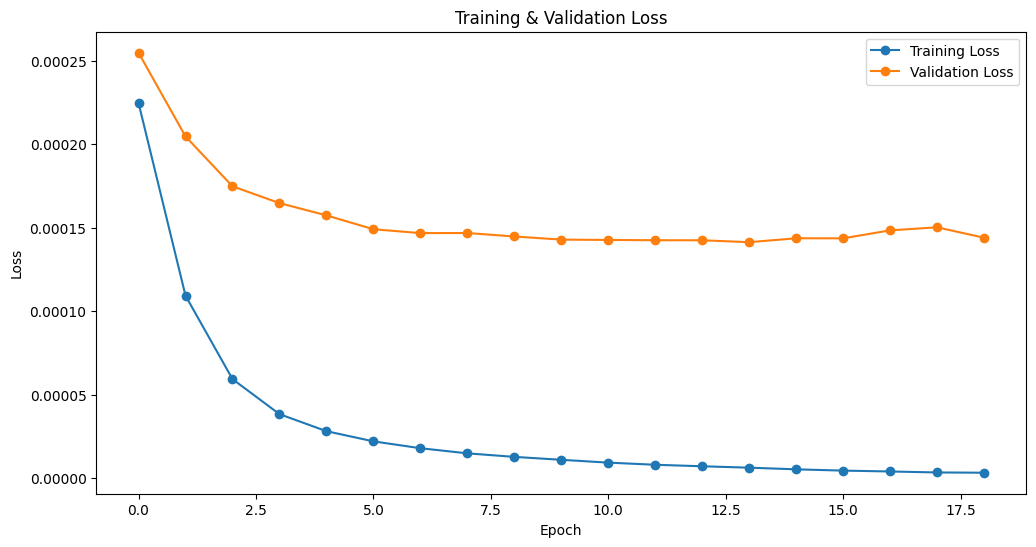

In [ ]:
plot_train_val_loss(summary_stats, save_figure_path="./figures/WDC_BERT_USE_train_val_loss.png")

## Evaluation

In [ ]:
model =  MulticlassClassifier('bert-base-uncased', output_dim=512)
model.load_state_dict(torch.load('models/WDC_BERT_USE_best.pth.tar'))
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)


test_outputs, _ = test(model, test_set) 
test_outputs = test_outputs.to('cpu')  # shape L x 768

test_outputs.shape, test_outputs.device, test_set[1].device

(torch.Size([1673, 512]), device(type='cpu'), device(type='cpu'))

In [ ]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
unique_labels = test_set[1]  # shape: b x 768

# test_outputs shape: a x 768, unique_labels shape: b x 768
similarity = cos(test_outputs[:,None], unique_labels) # shape: len(test_outputs) x len(unique_labels)
test_indices = test_set[2]  # ground truth


for val in [5, 10, 15, 20]:
  _, topk_indices = torch.topk(similarity, k=val, largest=True)
  _, recall = recall_at_k(topk_indices, test_indices)
  print('Recall at k={}:'.format(topk_indices.shape[1]), recall)
  prec = precision_at_k(topk_indices, test_indices)
  print('Precision at k={}:'.format(topk_indices.shape[1]), prec, '\n')

Recall at k=5: 0.9169157202630006
Precision at k=5: 0.18338314405260012 

Recall at k=10: 0.9414225941422594
Precision at k=10: 0.09414225941422594 

Recall at k=15: 0.9533771667662881
Precision at k=15: 0.06355847778441921 

Recall at k=20: 0.962940824865511
Precision at k=20: 0.048147041243275554 



# Summary

**SENTENCE BERT:**

Recall at k=5: 0.9127316198445905,
Precision at k=5: 0.18254632396891812 

Recall at k=10: 0.9426180514046623,
Precision at k=10: 0.09426180514046623 

Recall at k=15: 0.9539748953974896,
Precision at k=15: 0.06359832635983263 

Recall at k=20: 0.9623430962343096,
Precision at k=20: 0.04811715481171548 


**USE:**

Recall at k=5: 0.9169157202630006,
Precision at k=5: 0.18338314405260012 

Recall at k=10: 0.9414225941422594,
Precision at k=10: 0.09414225941422594 

Recall at k=15: 0.9533771667662881,
Precision at k=15: 0.06355847778441921 

Recall at k=20: 0.962940824865511,
Precision at k=20: 0.048147041243275554 


**MPNET:**

Recall at k=5: 0.9079497907949791,
Precision at k=5: 0.1815899581589958 

Recall at k=10: 0.9444112372982666,
Precision at k=10: 0.09444112372982666 

Recall at k=15: 0.9575612671846981,
Precision at k=15: 0.06383741781231321 

Recall at k=20: 0.9635385534967125,
Precision at k=20: 0.048176927674835626